In [5]:
import pandas as pd
import numpy as np
import pyreadstat
# import xlwings as xlw
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import sys
from os import listdir
from sklearn.neighbors import KernelDensity
from IPython.display import clear_output
import cufflinks as cf
from unidecode import unidecode
import ipystata
from linearmodels.panel import PanelOLS

sns.set()
# sns.set_style("darkgrid")

cf.go_offline()

# Definiciones

In [7]:
variables_relevantes = ['ciudad','secemp','fexp','p02','p03','p10a','area','rama1','grupo1',
                        'p44f','p05a','p05b','p15','p40','p41','p42','p43',
                        'ref','ingpc','ingrl','p63','p64b','p65','p66','p67','p68b','p69','p70b','p71b','p72b','p73b','p74b','p76','p77','p77a','p77b','p78','p78a','p78b','p78c']
grupo_edades = pd.IntervalIndex.from_tuples([(0, 20), (21, 30), (31, 40), (41,50), (51,60), (61,200)])
lista_archivos = [s.replace('.sav', '') for s in listdir() if '.sav' in s]
lista_archivos = [s for s in lista_archivos if s >= '200712']
# lista_archivos = ['201012','201612']

df_data = pd.read_excel('data.xlsx','data',3)
df_data['year'] = df_data.year.astype(str)+'12'
df_data.set_index('year', inplace=True)

print(lista_archivos)

df_t, meta_t = pyreadstat.read_sav('201612'+'.sav', metadataonly=True)
provincias = meta_t.variable_value_labels['prov']
lista_amazonia = ['Morona Santiago','Napo','Pastaza','Zamora Chinchipe','Sucumbíos','Orellana']
for k in provincias:
    if provincias[k] in lista_amazonia:
        provincias[k] = 'Amazonía'

provincias[24]='Guayas'
provincias[23]='Pichincha'

print(provincias)

['200712', '200812', '200912', '201012', '201112', '201212', '201312', '201412', '201512', '201612', '201712', '201812', '201912']
{1.0: 'Azuay', 2.0: 'Bolívar', 3.0: 'Cañar', 4.0: 'Carchi', 5.0: 'Cotopaxi', 6.0: 'Chimborazo', 7.0: 'El Oro', 8.0: 'Esmeraldas', 9.0: 'Guayas', 10.0: 'Imbabura', 11.0: 'Loja', 12.0: 'Los Ríos', 13.0: 'Manabí', 14.0: 'Amazonía', 15.0: 'Amazonía', 16.0: 'Amazonía', 17.0: 'Pichincha', 18.0: 'Tungurahua', 19.0: 'Amazonía', 20.0: 'Galapagos', 21.0: 'Amazonía', 22.0: 'Amazonía', 23.0: 'Pichincha', 24.0: 'Guayas', 90.0: 'Zonas no Delimitadas'}


In [8]:
def intersection(lst1, lst2): 
    lst3 = [value for value in lst1 if value in lst2] 
    return lst3

def read_meta(file):
    df, meta = pyreadstat.read_sav(file+'.sav', metadataonly=True)
    return meta

def read_columns(file):
    df, meta = pyreadstat.read_sav(file+'.sav', metadataonly=True)
    columns = [s.lower() for s in df.columns]
    return columns

def weight_array(ar, weights):
    zipped = zip(ar, weights)
    weighted = []
    for i in zipped:
        for j in range(i[1]):
            weighted.append(i[0])
    return np.array(weighted)

def weighted_qcut(values, weights, q, **kwargs):
    'Return weighted quantile cuts from a given series, values.'
    if type(q)==int:
        quantiles = np.linspace(0, 1, q + 1)
    else:
        quantiles = q
    order = weights.iloc[values.argsort()].cumsum()
    bins = pd.cut(order / order.iloc[-1], quantiles, labels=False, **kwargs)
    return bins.sort_index()

def weighted_percentile(data, percents, weights=None):
    if weights is None:
        return np.percentile(data, percents)
    ind=np.argsort(data)
    d=data.iloc[ind]
    w=weights.iloc[ind]
    p=1.*w.cumsum()/w.sum()*100
    y=np.interp(percents, p, d)
    return y

def weighted_percentileofscore(values, weights=None, values_sorted=False):
    """ Similar to scipy.percentileofscore, but supports weights.
    :param values: array-like with data.
    :param weights: array-like of the same length as `values`.
    :param values_sorted: bool, if True, then will avoid sorting of initial array.
    :return: numpy.array with percentiles of sorted array.
    """
    values = np.array(values)
    if weights is None:
        weights = np.ones(len(values))
    weights = np.array(weights)

    if not values_sorted:
        sorter = np.argsort(values)
        values = values[sorter]
        weights = weights[sorter]

    total_weight = weights.sum()
    return 100 * np.cumsum(weights) / total_weight

def read_sav(file):
    'Lee el archivo .sav y devuelve un dataframe'  
    df, meta = pyreadstat.read_sav(file+'.sav', metadataonly=False)
    
    # Selecciona solo columnas relevantes:
    df = df[intersection(df.columns, variables_relevantes)]
    
    # Crea columna provincia y mapea con el nombre:
    df['ciudad'] = df['ciudad'].astype('int')
    df['provincia'] = df['ciudad'].astype('str').str[:-4].astype('int').map(provincias)
    
    df.dropna(subset=['ingrl','provincia'], inplace=True)
    condition = ((df.ingrl != 999999) & (df.ingrl >= 0) & (df.p03 >= 15))
    df = df[condition]
    
    # Crea columnas con descripción de las variables
    labels = meta.variable_value_labels
    for var in intersection(df.columns, labels.keys()):
        df[var+'_desc'] = df[var].map(labels[var]).fillna(df[var])
    
    print(file,end=' | ')
    return df

# Importación de datos

In [9]:
# if input('Actualizar desde bases .sav (y/n)?').lower() == 'y':
if False:    
    df_dict = {file:read_sav(file) for file in lista_archivos}
    meta_dict = {file:read_meta(file) for file in lista_archivos}
    df = pd.concat(df_dict.values(),keys=df_dict.keys(),sort=False).reset_index().rename(columns={"level_0":"year"})
    del df_dict
    df.to_pickle('df_enemdu')
#     meta_dict.to_pickle()
else:
    df = pd.read_pickle('df_enemdu')
    meta_dict = {file:read_meta(file) for file in lista_archivos}
clear_output(wait=True)

# Reemplazo de perdidos --------------------------------
df['p67'] = np.where(df.p67==999999, 0, df.p67)
df['p66'] = np.where(df.p66==999999, 0, df.p66)
print('Dim 1',df.shape)

# Nuevas variables -------------------------------------
a = list(df.columns)

df = df.merge(df_data, how='left', left_on='year', right_index=True)
df['laggedyear'] = (df.year.astype(int).add(-100).astype(str))
df = df.merge(df_data, how='left', left_on='laggedyear', right_index=True, suffixes=('','_lag'))

df['v1'] = 1
df['grupo_edad'] = pd.cut(df.p03, grupo_edades)
df['informal_ss'] = np.where(np.isin(df.p05a,[1,2,3,4]), 'formal_ss', 'informal_ss') # Informalidad por seguridad social
df['ingrsal'] = df.p66.add(df.p67)
df['ingrcp'] = df.ingrl.add(-df.ingrsal)
df[['ingrsal','ingrcp']] = df[['ingrsal','ingrcp']].fillna(0)
df['p_provincial'] = df.groupby(['year','provincia']).apply(lambda x: weighted_qcut(x.ingrl,x.fexp,10)).reset_index([0,1],drop=True)
df['p_nacional'] = df.groupby(['year']).apply(lambda x: weighted_qcut(x.ingrl,x.fexp,10)).reset_index(0,drop=True)
for var in ['ingrl','ingrsal','ingrcp']:
    df[var+'_r'] = df[var]/df['ipc']*100
    df[var+'_ppp'] = df[var]/df['ppp_factor']
    df['fa_'+var] = np.where((df[var] >= df.sbu*0.9) & (df[var] <= df.sbu*1.1),'fa_'+var,'nfa_'+var)
    df['fb_'+var] = np.where(df[var] < df.sbu*0.9,'fb_'+var,'nfb_'+var)
    df['faf_'+var] = np.where((df[var] >= df.sbu_lag) & (df[var] <= df.sbu),'faf_'+var,'nfaf_'+var)
    
print('Dim 2',df.shape, set(df.columns) - set(a))

# Agrupación de datos

df['p15_desc'] = np.where( np.isin(df.p15_desc,['Mulato','Negro']), 'Afroecuatoriano', df.p15_desc )
df['p15_desc'] = np.where( np.isin(df.p15_desc,['Otro, cual','Montubio']) , 'Indígena', df.p15_desc )

df['p10a_desc'] = np.where( np.isin(df.p10a_desc,['Ninguno', 'Centro de alfabetización']) , 'sin_educacion', df.p10a_desc )
df['p10a_desc'] = np.where( np.isin(df.p10a_desc,['Educación Básica', 'Primaria']) , 'primaria', df.p10a_desc )
df['p10a_desc'] = np.where( np.isin(df.p10a_desc,['Educación  Media', 'Educación Media', 'Secundaria']) , 'secundaria', df.p10a_desc )
df['p10a_desc'] = np.where( np.isin(df.p10a_desc,['Superior Universitario', 'Superior no universitario', 'Post-grado']) , 'terciaria', df.p10a_desc )

df['area_desc'] = np.where(df.area == 1,'Urbano', 'Rural')


# Elimina filas no deseadas -------------------------
a = df.shape[0]

condition = ((df.ingrl != 0) & (df.provincia != 'Zonas no Delimitadas') & (df.provincia != 'Galapagos') & (df.ingrl>0))# & (df.p_provincial != 99))
df = df[condition]

print('Dim 3',df.shape,df.shape[0]-a)

# df.head()

Dim 1 (431287, 78)
Dim 2 (431287, 113) {'grupo_edad', 'ingrcp_ppp', 'ingrsal', 'ingrcp', 'sbu_r_lag', 'ingrcp_r', 'ingrl_r', 'ingrl_ppp', 'tcambio_lag', 'fb_ingrsal', 'ppp_factor', 'faf_ingrl', 'ppp_factor_lag', 'p_nacional', 'fb_ingrcp', 'sbu_ppp_lag', 'ingrsal_r', 'v1', 'sbu_r', 'tcambio', 'faf_ingrsal', 'ingrsal_ppp', 'sbu', 'faf_ingrcp', 'fa_ingrcp', 'ipc_lag', 'p_provincial', 'sbu_ppp', 'sbu_lag', 'fb_ingrl', 'informal_ss', 'fa_ingrsal', 'fa_ingrl', 'laggedyear', 'ipc'}
Dim 3 (412747, 113) -18540


In [6]:
for col in df.columns:
    print(col, end=' ')

year level_1 area ciudad p02 p03 p05a p05b p10a p15 p40 p41 p42 p43 p44f p63 p64b p65 p66 p67 p68b p69 p70b p71b p72b p73b p74b p76 p77a p77b p78 fexp secemp ingrl ingpc rama1 grupo1 provincia area_desc p02_desc p03_desc p05a_desc p05b_desc p10a_desc p15_desc p40_desc p41_desc p42_desc p43_desc p44f_desc p63_desc p64b_desc p65_desc p66_desc p67_desc p68b_desc p69_desc p70b_desc p71b_desc p72b_desc p73b_desc p74b_desc p76_desc p77a_desc p77b_desc p78_desc secemp_desc ingrl_desc rama1_desc grupo1_desc p78a p78b p78c p78a_desc p78b_desc p78c_desc p77 p77_desc ppp_factor ipc tcambio sbu sbu_r sbu_ppp laggedyear ppp_factor_lag ipc_lag tcambio_lag sbu_lag sbu_r_lag sbu_ppp_lag v1 grupo_edad informal_ss ingrsal ingrcp p_provincial p_nacional ingrl_r ingrl_ppp fa_ingrl fb_ingrl faf_ingrl ingrsal_r ingrsal_ppp fa_ingrsal fb_ingrsal faf_ingrsal ingrcp_r ingrcp_ppp fa_ingrcp fb_ingrcp faf_ingrcp 

In [7]:
# xlw.Book('smin.xlsx').sheets('Sheet3').range('A1').value = df.dropna(subset=['ingrl']).sample(10000)
# df[['p43','p43_desc']].drop_duplicates()
# df[['area','area_desc']].drop_duplicates().sort_values('area')

In [ ]:
df_t = df[df.year=='201712']
pd.crosstab([df_t.grupo1,df_t.grupo1_desc],[df_t.year,df_t.rama1_desc.str[0],df_t.p02_desc],df_t.fexp,aggfunc=np.sum).to_clipboard() #.xs('Mujer',axis=1,level=1,drop_level=False)

# Densidades

In [ ]:
%%time
# years = [str(i) for i in list(range(200712,201812,100))]
years = ['200712','201212','201712']
fig, axs = plt.subplots(2,len(years),sharey=True,sharex=True, figsize=(20,7), dpi=200)
colors = ['red','blue','green','navy','orange']
# fig.suptitle('Densidades de ingresos laborales, cuenta propia y salarios')

for i,year in enumerate(years):
    P = 100
    hl = list()
    variables = {'ingrsal_r':'Salarios',
                 'ingrcp_r':'Cuentas Propias',}
#                  'ingrl_r':'Laboral'}
    for var in variables.keys():
        cond = (df[var]>0) & (df['year']==year)
        df_t = df[cond][[var,'fexp']]
        X = np.log(np.array(df_t.iloc[:,0]).reshape(-1, 1))
        S = df_t.iloc[:,1]
        h = X.std()*(4/3/X.size)**(1/10) # Silverman rule of thumb for kernel bandwith
        hl.append(np.round(h,3))
        kde = KernelDensity(bandwidth=h,kernel='epanechnikov').fit(X=X, sample_weight=S)
        x_plot = np.linspace(X.min(), X.max(), P).reshape(-1,1)
        y_plot = np.exp(kde.score_samples(x_plot))
        y_plot_c = np.cumsum(y_plot)/np.cumsum(y_plot)[-1]
        axs[0,i].plot(x_plot,y_plot,label=variables[var])
        axs[1,i].plot(x_plot,y_plot_c,label=variables[var])
        print(year, variables[var])
        clear_output(wait=True)
    
    axs[0,i].axvspan(np.log(df_data.sbu_r[year]*0.90),np.log(df_data.sbu_r[year]*1.10), alpha=0.25, color='grey')
    axs[0,i].axvline(np.log(df_data.sbu_r[year]), label='MW', ls=':', color='black')
    axs[1,i].axvline(np.log(df_data.sbu_r[year]), label='MW', ls=':', color='black')
    
    axs[0,i].set_title(year[0:4]+'\n'+'h='+str(hl),loc='right')
    if i==0:
        axs[0,i].legend()

# plt.xlim((0,1000))

axs[1,0].axhline(0.41, label='MW', ls='--', color='navy', alpha=0.3)
axs[1,1].axhline(0.39, label='MW', ls='--', color='navy', alpha=0.3)
axs[1,2].axhline(0.38, label='MW', ls='--', color='navy', alpha=0.3)

axs[1,0].axhline(0.94, label='MW', ls='--', color='darkorange', alpha=0.3)
axs[1,1].axhline(0.99, label='MW', ls='--', color='darkorange', alpha=0.3)
axs[1,2].axhline(0.99, label='MW', ls='--', color='darkorange', alpha=0.3)

plt.xlim((1,8))
plt.savefig('densidades.png',dpi=300)
plt.show()

In [ ]:
years = enumerate([str(i) for i in list(range(200712,201912,100))])
iss = range(0,13,1)


In [ ]:
# [type(i%2) for i in iss]
# [(int((i-i%2)/2)) for i in iss]
len(years)
(int(len(years)/cols),cols)

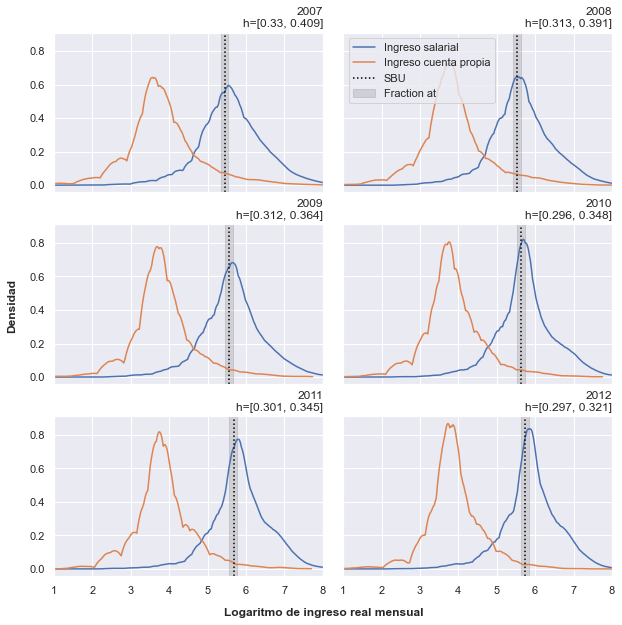

Wall time: 53.2 s


In [10]:
%%time
years = [str(i) for i in list(range(200712,201312,100))]
cols = 2

fig, axs = plt.subplots(int(len(years)/cols),cols,sharey=True,sharex=True,figsize=(10,10), gridspec_kw={'wspace':.075})

colors = ['red','blue','green','navy','orange']
# fig.suptitle('Densidades de ingresos laborales, cuenta propia y salarios')

for i,year in enumerate(years):
    P = 2000
    hl = list()
    variables = {'ingrsal_r':'Ingreso salarial',
                 'ingrcp_r':'Ingreso cuenta propia',}
#                  'ingrl_r':'Laboral'}
    for var in variables.keys():
        cond = (df[var]>0) & (df['year']==year)
        df_t = df[cond][[var,'fexp']]
        X = np.log(np.array(df_t.iloc[:,0]).reshape(-1, 1))
        S = df_t.iloc[:,1]
        h = X.std()*(4/3/X.size)**(1/10) # Silverman rule of thumb for kernel bandwith
        hl.append(np.round(h,3))
        kde = KernelDensity(bandwidth=h,kernel='epanechnikov').fit(X=X, sample_weight=S)
        x_plot = np.linspace(X.min(), X.max(), P).reshape(-1,1)
        y_plot = np.exp(kde.score_samples(x_plot))
        y_plot_c = np.cumsum(y_plot)/np.cumsum(y_plot)[-1]
        axi = int((i-i%cols)/cols)
        axj = i%2        
        axs[axi,axj].plot(x_plot,y_plot,label=variables[var])
#         axs[1,i].plot(x_plot,y_plot_c,label=variables[var])
        print(year, variables[var])
        clear_output(wait=True)
        
    axs[axi,axj].axvspan(np.log(df_data.sbu_r[year]*0.90),np.log(df_data.sbu_r[year]*1.10), alpha=0.25, color='grey', label='Fraction at')
    axs[axi,axj].axvline(np.log(df_data.sbu_r[year]), label='SBU', ls=':', color='black')

    axs[axi,axj].set_title(year[0:4]+'\n'+'h='+str(hl),loc='right') #,fontdict = {'fontsize' : 9})
    
fig.text(0.5, 0.07, 'Logaritmo de ingreso real mensual', ha='center', fontdict = {'fontsize' : 12,'weight': 'bold'})
fig.text(0.06, 0.5, 'Densidad', va='center', rotation='vertical', fontdict = {'fontsize' : 12,'weight': 'bold'})
axs[0,1].legend(loc = 'upper left')

# fig.set_xlabel('common xlabel')
# fig.set_ylabel('common ylabel')
# fig.text(0.5, 0.04, 'common xlabel', ha='center', va='center')
# fig.text(0.06, 0.5, 'common ylabel', ha='center', va='center', rotation='vertical')

plt.xlim((1,8))
plt.savefig('densidades1.png',dpi=300,bbox_inches='tight')
plt.show()

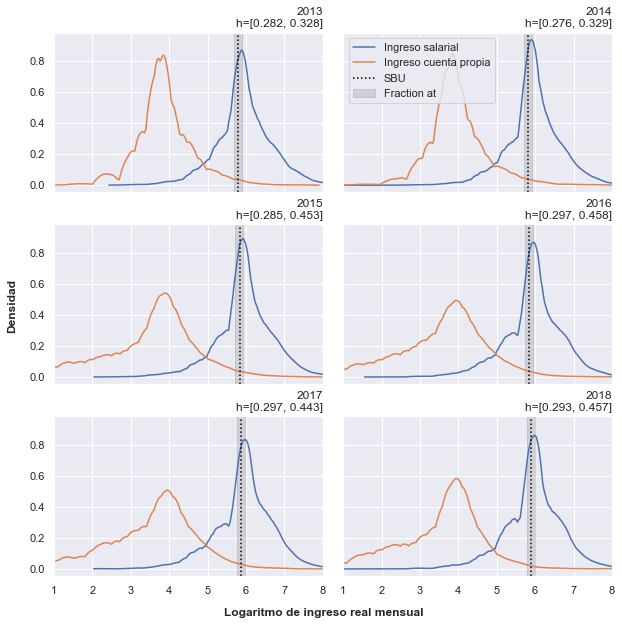

Wall time: 49.5 s


In [12]:
%%time
years = [str(i) for i in list(range(201312,201912,100))]
cols = 2

fig, axs = plt.subplots(int(len(years)/cols),cols,sharey=True,sharex=True,figsize=(10,10), gridspec_kw={'wspace':.075})

colors = ['red','blue','green','navy','orange']
# fig.suptitle('Densidades de ingresos laborales, cuenta propia y salarios')

for i,year in enumerate(years):
    P = 2000
    hl = list()
    variables = {'ingrsal_r':'Ingreso salarial',
                 'ingrcp_r':'Ingreso cuenta propia',}
#                  'ingrl_r':'Laboral'}
    for var in variables.keys():
        cond = (df[var]>0) & (df['year']==year)
        df_t = df[cond][[var,'fexp']]
        X = np.log(np.array(df_t.iloc[:,0]).reshape(-1, 1))
        S = df_t.iloc[:,1]
        h = X.std()*(4/3/X.size)**(1/10) # Silverman rule of thumb for kernel bandwith
        hl.append(np.round(h,3))
        kde = KernelDensity(bandwidth=h,kernel='epanechnikov').fit(X=X, sample_weight=S)
        x_plot = np.linspace(X.min(), X.max(), P).reshape(-1,1)
        y_plot = np.exp(kde.score_samples(x_plot))
        y_plot_c = np.cumsum(y_plot)/np.cumsum(y_plot)[-1]
        axi = int((i-i%cols)/cols)
        axj = i%2        
        axs[axi,axj].plot(x_plot,y_plot,label=variables[var])
#         axs[1,i].plot(x_plot,y_plot_c,label=variables[var])
        print(year, variables[var])
        clear_output(wait=True)
        
    axs[axi,axj].axvspan(np.log(df_data.sbu_r[year]*0.90),np.log(df_data.sbu_r[year]*1.10), alpha=0.25, color='grey', label='Fraction at')
    axs[axi,axj].axvline(np.log(df_data.sbu_r[year]), label='SBU', ls=':', color='black')

    axs[axi,axj].set_title(year[0:4]+'\n'+'h='+str(hl),loc='right') #,fontdict = {'fontsize' : 9})
    
fig.text(0.5, 0.07, 'Logaritmo de ingreso real mensual', ha='center', fontdict = {'fontsize' : 12,'weight': 'bold'})
fig.text(0.06, 0.5, 'Densidad', va='center', rotation='vertical', fontdict = {'fontsize' : 12,'weight': 'bold'})
axs[0,1].legend(loc = 'upper left')

# fig.set_xlabel('common xlabel')
# fig.set_ylabel('common ylabel')
# fig.text(0.5, 0.04, 'common xlabel', ha='center', va='center')
# fig.text(0.06, 0.5, 'common ylabel', ha='center', va='center', rotation='vertical')

plt.xlim((1,8))
plt.savefig('densidades2.png',dpi=300,bbox_inches='tight')
plt.show()

# Armado del Panel

In [11]:
d1=dict()
for item in df.groupby(['provincia','year']):
    d1[item[0]] = weighted_percentile(item[1].ingrl_r,range(10,110,10), item[1].fexp)
    print('Laboral ',item[0][1],item[0][0])
    clear_output(wait=True)

panel = pd.DataFrame.from_dict(d1).T
panel.columns = ['lab'+str(i) for i in range(1,11,1)]
panel.index.set_names(['provincia','year'], inplace=True)
list_df = list()

d1=dict()
for item in df[df.ingrsal_r>0].groupby(['provincia','year']):
    d1[item[0]] = weighted_percentile(item[1].ingrsal_r,range(10,110,10), item[1].fexp)
    print('Salarial ',item[0][1],item[0][0])
    clear_output(wait=True)

panel1 = pd.DataFrame.from_dict(d1,).T
panel1.columns = ['sal'+str(i) for i in range(1,11,1)]
panel1.index.set_names(['provincia','year'], inplace=True)
list_df.append(panel1)

d1=dict()
for item in df[df.ingrcp_r>0].groupby(['provincia','year']):
    d1[item[0]] = weighted_percentile(item[1].ingrcp_r,range(10,110,10), item[1].fexp)
    print('Cuenta Propia ',item[0][1],item[0][0])
    clear_output(wait=True)

panel1 = pd.DataFrame.from_dict(d1,).T
panel1.columns = ['cp'+str(i) for i in range(1,11,1)]
panel1.index.set_names(['provincia','year'], inplace=True)
list_df.append(panel1)

list_df.append(df.pivot_table('sbu_r', ['provincia','year'])) # SBU OK
list_df.append(pd.crosstab([df.provincia,df.year],[df.fa_ingrl], df.fexp, aggfunc=np.sum, normalize='index', dropna=False))  # Fraction at ingreso laboral
list_df.append(pd.crosstab([df.provincia,df.year],[df.fa_ingrsal], df.fexp, aggfunc=np.sum, normalize='index', dropna=False))  # Fraction at ingreso salarial
list_df.append(pd.crosstab([df.provincia,df.year],[df.fa_ingrcp], df.fexp, aggfunc=np.sum, normalize='index', dropna=False))  # Fraction at ingreso cuenta propia
list_df.append(pd.crosstab([df.provincia,df.year],[df.fb_ingrl], df.fexp, aggfunc=np.sum, normalize='index', dropna=False))  # Fraction below ingreso laboral
list_df.append(pd.crosstab([df.provincia,df.year],[df.fb_ingrsal], df.fexp, aggfunc=np.sum, normalize='index', dropna=False))  # Fraction below ingreso salarial
list_df.append(pd.crosstab([df.provincia,df.year],[df.fb_ingrcp], df.fexp, aggfunc=np.sum, normalize='index', dropna=False))  # Fraction below ingreso cuenta propia
list_df.append(pd.crosstab([df.provincia,df.year],[df.faf_ingrl], df.fexp, aggfunc=np.sum, normalize='index', dropna=False))  # Fraction affected ingreso laboral
list_df.append(pd.crosstab([df.provincia,df.year],[df.faf_ingrsal], df.fexp, aggfunc=np.sum, normalize='index', dropna=False))  # Fraction affected ingreso salarial
list_df.append(pd.crosstab([df.provincia,df.year],[df.faf_ingrcp], df.fexp, aggfunc=np.sum, normalize='index', dropna=False))  # Fraction affected ingreso cuenta propia

list_df.append(pd.crosstab([df.provincia,df.year],[df.informal_ss], df.fexp, aggfunc=np.sum, normalize='index', dropna=False)) # Informalidad por seguridad social OK
list_df.append(pd.crosstab([df.provincia,df.year],[df.p02_desc], df.fexp, aggfunc=np.sum, normalize='index', dropna=False)) # Sexo OK
list_df.append(pd.crosstab([df.provincia,df.year],[df.p15_desc], normalize='index', dropna=False)) # Etnia OK
list_df.append(pd.crosstab([df.provincia,df.year],[df.p10a_desc], df.fexp, aggfunc=np.sum, normalize='index', dropna=False)) # Nivel de educación OK
list_df.append(pd.crosstab([df.provincia,df.year],[df.area_desc], df.fexp, aggfunc=np.sum, normalize='index', dropna=False)) # Urbano o rural OK
# list_df.append(pd.crosstab([df.provincia,df.year],[df.grupo1_desc], df.fexp, aggfunc=np.sum, normalize='index', dropna=False)) # Industria
list_df.append(pd.crosstab([df.provincia,df.year],[df.rama1_desc.str[0]], df.fexp, aggfunc=np.sum, normalize='index', dropna=False)) # Industria

for item in list_df:
    panel = panel.merge(item, how='left', left_index=True, right_index=True)

for col in [col for col in panel.columns if col.startswith(('lab','sal','cp','sbu'))]:
    panel['l'+col] = np.log(panel[col])
    panel['dl'+col] = panel['l'+col].groupby(level=0).transform(pd.DataFrame.diff)

for col in [col for col in panel.columns if col.startswith(('fa_','fb_','faf_'))]:
    panel['d'+col] = panel[col].groupby(level=0).transform(pd.DataFrame.diff)

# panel.columns = [str(col) for col in panel.columns]
panel.reset_index(inplace=True)
panel.columns = [unidecode(str(col).lower().replace(' ','_')) for col in panel.columns]
panel['year'] = panel.year.str[0:4].astype(int)
panel['provincia'] = panel.provincia.apply(unidecode)
panel = panel[panel.year<2018]
panel.set_index(['provincia','year'], inplace=True)
# panel

for col in panel.columns:
    print(col, end=' ')

lab1 lab2 lab3 lab4 lab5 lab6 lab7 lab8 lab9 lab10 sal1 sal2 sal3 sal4 sal5 sal6 sal7 sal8 sal9 sal10 cp1 cp2 cp3 cp4 cp5 cp6 cp7 cp8 cp9 cp10 sbu_r fa_ingrl nfa_ingrl fa_ingrsal nfa_ingrsal fa_ingrcp nfa_ingrcp fb_ingrl nfb_ingrl fb_ingrsal nfb_ingrsal fb_ingrcp nfb_ingrcp faf_ingrl nfaf_ingrl faf_ingrsal nfaf_ingrsal faf_ingrcp nfaf_ingrcp formal_ss informal_ss hombre mujer afroecuatoriano blanco indigena mestizo primaria secundaria sin_educacion terciaria rural urbano a b c d e f g h i j k l m n o p q r s t u llab1 dllab1 llab2 dllab2 llab3 dllab3 llab4 dllab4 llab5 dllab5 llab6 dllab6 llab7 dllab7 llab8 dllab8 llab9 dllab9 llab10 dllab10 lsal1 dlsal1 lsal2 dlsal2 lsal3 dlsal3 lsal4 dlsal4 lsal5 dlsal5 lsal6 dlsal6 lsal7 dlsal7 lsal8 dlsal8 lsal9 dlsal9 lsal10 dlsal10 lcp1 dlcp1 lcp2 dlcp2 lcp3 dlcp3 lcp4 dlcp4 lcp5 dlcp5 lcp6 dlcp6 lcp7 dlcp7 lcp8 dlcp8 lcp9 dlcp9 lcp10 dlcp10 lsbu_r dlsbu_r dfa_ingrl dfa_ingrsal dfa_ingrcp dfb_ingrl dfb_ingrsal dfb_ingrcp dfaf_ingrl dfaf_ingrsal d

In [13]:
panel.head()

lab1        lab2        lab3        lab4        lab5  \
provincia year                                                              
Amazonia  2007  50.322251   85.626458  136.246405  189.414450  245.243529   
          2008  62.595666  100.153066  150.229599  200.306132  250.382665   
          2009  48.006611   84.011569  141.619503  180.024792  217.598266   
          2010  58.075491  116.150982  162.611375  216.753996  278.762357   
          2011  57.031872  110.190364  165.285546  220.380728  286.494947   

                      lab6        lab7        lab8        lab9         lab10  \
provincia year                                                                 
Amazonia  2007  313.366732  408.739215  544.985620  817.478431  37274.291506   
          2008  325.497465  438.169664  600.918397  826.262796  19404.656565   
          2009  281.626709  354.048757  488.131515  734.345237   6540.900758   
          2010  330.680358  383.530567  546.363070  782.798978   4953.839393   
          2011  363.628202  440.761457  612.343979  984.648207   6060.470032   

                ...   dlsbu_r  dfa_ingrl  dfa_ingrsal  dfa_ingrcp  dfb_ingrl  \
provincia year  ...                                                            
Amazonia  2007  ...       NaN        NaN          NaN         NaN        NaN   
          2008  ...  0.077897   0.045046     0.035791    0.006129  -0.007225   
          2009  ...  0.043964  -0.009124    -0.001727   -0.005936   0.071734   
          2010  ...  0.063405   0.016550     0.013099    0.000635  -0.046521   
          2011  ...  0.042629  -0.021837    -0.033761   -0.000717  -0.009813   

                dfb_ingrsal  dfb_ingrcp  dfaf_ingrl  dfaf_ingrsal  dfaf_ingrcp  
provincia year                                                                  
Amazonia  2007          NaN         NaN         NaN           NaN          NaN  
          2008    -0.007210   -0.005366    0.066562      0.040709     0.007551  
          2009     0.027604    0.017493   -0.038522     -0.016008    -0.005936  
          2010    -0.002879   -0.007295    0.006554      0.004125    -0.001363  
          2011    -0.037378    0.003791   -0.015523     -0.020191     0.000485  

[5 rows x 155 columns]

# Modelo

In [9]:
mod = PanelOLS(panel.dllab1, panel.dfa_ingrl, entity_effects=True)
res = mod.fit()
df_res = pd.DataFrame()

In [10]:
pd.DataFrame([res.params,res.pvalues.apply(star)])
# pd.DataFrame([res.pvalues.apply(star)])
panel.columns

NameError: name 'star' is not defined

In [ ]:
list_res = list()
for decil in range(1,11,1):
    res = PanelOLS.from_formula(f'dllab{decil} ~ dfa_ingrl + EntityEffects',panel).fit()
    list_res.append(pd.DataFrame(res.params.apply(np.round,args=(3,)).astype(str)+res.pvalues.apply(star),columns=['D'+str(decil)]))
#     res = PanelOLS.from_formula(f'dllab{decil} ~ dfa_ingrl + informal_ss + EntityEffects',panel).fit()
#     list_res.append(pd.DataFrame(res.params.apply(np.round,args=(3,)).astype(str)+res.pvalues.apply(star),columns=['D'+str(decil)]))

pd.concat(list_res,axis=1).T


In [ ]:
endog = 'dllab1'
exog = ['dlfa1']
control = 

In [ ]:
def star(pval):
    if pval<0.01:
        s=' ***'
    elif pval<0.05: 
        s=' **'
    elif pval<0.1:
        s=' *'
    else:
        s=' '
    return s

In [ ]:
star

In [ ]:
res.params.name

In [11]:
%%stata -d panel
cls
encode provincia, gen(cod_provincia)
xtset cod_provincia year
cd "C:\Users\alejo\OneDrive - Universidad de Las Américas\Proyectos\Salario Mínimo - Ecuador"

com_error: (-2147221005, 'Invalid class string', None, None)

In [ ]:
%%stata
display "hola"

**--------------------------INGRESO LABORAL------------------------------------------**

In [12]:
%%stata
cls
display "--------MODELO 1--------"
forvalues i = 1/9{
    quietly xtreg dllab`i' dfa_ingrl, fe
    estimates store m`i', title(Decil `i')
}
* esttab m1 m2 m3 m4 m5 m6 m7 m8 m9 using final1.csv, replace se(a2) compress title(Estimaciones) mtitles b(a2) starlevels(* 0.1 ** 0.05 *** 0.01) stats(r2 N)
estout m1 m2 m3 m4 m5 m6 m7 m8 m9, cells(b(star fmt(3)) se) keep(dfa_ingrl _cons) stats(N, fmt(0)) legend label varlabels(_cons constant) starlevels(* 0.1 ** 0.05 *** 0.01)
forvalues i = 1/9{
    quietly xtreg dllab`i' dfa_ingrl mujer afroecuatoriano blanco indigena primaria secundaria terciaria rural b c d e f g h i j k l m n o p q r s t u, fe
    estimates store m`i', title(Decil `i')
}
* esttab m1 m2 m3 m4 m5 m6 m7 m8 m9 using final2.csv, replace se(a2) compress title(Estimaciones) mtitles b(a2) starlevels(* 0.1 ** 0.05 *** 0.01) stats(r2 N)
estout m1 m2 m3 m4 m5 m6 m7 m8 m9, cells(b(star fmt(3))) keep(dfa_ingrl _cons) stats(N, fmt(0)) legend label varlabels(_cons constant) starlevels(* 0.1 ** 0.05 *** 0.01)
forvalues i = 1/9{
    quietly reg dllab`i' dfa_ingrl informal_ss mujer afroecuatoriano blanco indigena primaria secundaria terciaria rural  b c d e f g h i j k l m n o p q r s t u c.year i.cod_provincia c.year##i.cod_provincia
    estimates store m`i', title(Decil `i')
}
* esttab m1 m2 m3 m4 m5 m6 m7 m8 m9 using final3.csv, replace se(a2) compress title(Estimaciones) mtitles b(a2) starlevels(* 0.1 ** 0.05 *** 0.01) stats(r2 N)
estout m1 m2 m3 m4 m5 m6 m7 m8 m9, cells(b(star fmt(3))) keep(dfa_ingrl informal_ss _cons) stats(N, fmt(0)) legend label varlabels(_cons constant) starlevels(* 0.1 ** 0.05 *** 0.01)

com_error: (-2147221005, 'Invalid class string', None, None)

In [20]:
%%stata
display "--------MODELO 2--------"
forvalues i = 1/9{
    quietly xtreg dllab`i' dfa_ingrl dfa_ingrsal dfa_ingrcp, fe
    estimates store m`i', title(Decil `i')
}
*esttab m1 m2 m3 m4 m5 m6 m7 m8 m9 using final1.csv, replace se(a2) compress title(Estimaciones) mtitles b(a2) starlevels(* 0.1 ** 0.05 *** 0.01) stats(r2 N)
estout m1 m2 m3 m4 m5 m6 m7 m8 m9, cells(b(star fmt(3))) stats(N, fmt(0)) legend label varlabels(_cons constant) starlevels(* 0.1 ** 0.05 *** 0.01)

forvalues i = 1/9{
    quietly xtreg dllab`i' dfa_ingrl dfa_ingrsal dfa_ingrcp mujer afroecuatoriano blanco indigena primaria secundaria terciaria rural b c d e f g h i j k l m n o p q r s t u, fe
    estimates store m`i', title(Decil `i')
}
*esttab m1 m2 m3 m4 m5 m6 m7 m8 m9 using final2.csv, replace se(a2) compress title(Estimaciones) mtitles b(a2) starlevels(* 0.1 ** 0.05 *** 0.01) stats(r2 N)
estout m1 m2 m3 m4 m5 m6 m7 m8 m9, cells(b(star fmt(3))) drop(mujer afroecuatoriano blanco indigena primaria secundaria terciaria rural b c d e f g h i j k l m n o p q r s t u) stats(N, fmt(0)) legend label varlabels(_cons constant) starlevels(* 0.1 ** 0.05 *** 0.01)

forvalues i = 1/9{
    quietly xtreg dllab`i' dfa_ingrl dfa_ingrsal dfa_ingrcp informal_ss mujer afroecuatoriano blanco indigena primaria secundaria terciaria rural b c d e f g h i j k l m n o p q r s t u, fe
    
    estimates store m`i', title(Decil `i')
}
*esttab m1 m2 m3 m4 m5 m6 m7 m8 m9 using final3.csv, replace se(a2) compress title(Estimaciones) mtitles b(a2) starlevels(* 0.1 ** 0.05 *** 0.01) stats(r2 N)
estout m1 m2 m3 m4 m5 m6 m7 m8 m9, cells(b(star fmt(3))) drop(mujer afroecuatoriano blanco indigena primaria secundaria terciaria rural b c d e f g h i j k l m n o p q r s t u) stats(N, fmt(0)) legend label varlabels(_cons constant) starlevels(* 0.1 ** 0.05 *** 0.01)

--------MODELO 2--------

------------------------------------------------------------------------------------------------------------------------------------------------------------------
                          Decil 1         Decil 2         Decil 3         Decil 4         Decil 5         Decil 6         Decil 7         Decil 8         Decil 9 
                                b               b               b               b               b               b               b               b               b 
------------------------------------------------------------------------------------------------------------------------------------------------------------------
dfa_ingrl                   1.312           0.891           0.083          -0.113          -0.177          -0.233          -0.331          -0.278           0.050 
dfa_ingrsal                 1.786           1.390           1.762**         1.781**         1.136*          0.471           0.261           0.103          -0.0

In [85]:
%%stata
display "--------MODELO 2--------"
forvalues i = 1/9{
    quietly xtreg dllab`i' dfa_ingrl dfa_ingrsal dfa_ingrcp, fe
    estimates store m`i', title(Decil `i')
}
*esttab m1 m2 m3 m4 m5 m6 m7 m8 m9 using final1.csv, replace se(a2) compress title(Estimaciones) mtitles b(a2) starlevels(* 0.1 ** 0.05 *** 0.01) stats(r2 N)
estout m1 m2 m3 m4 m5 m6 m7 m8 m9, cells(b(star fmt(3))) stats(N, fmt(0)) legend label varlabels(_cons constant) starlevels(* 0.1 ** 0.05 *** 0.01)

forvalues i = 1/9{
    quietly xtreg dllab`i' dfa_ingrl dfa_ingrsal dfa_ingrcp mujer afroecuatoriano blanco indigena primaria secundaria terciaria rural b c d e f g h i j k l m n o p q r s t u, fe
    estimates store m`i', title(Decil `i')
}
*esttab m1 m2 m3 m4 m5 m6 m7 m8 m9 using final2.csv, replace se(a2) compress title(Estimaciones) mtitles b(a2) starlevels(* 0.1 ** 0.05 *** 0.01) stats(r2 N)
estout m1 m2 m3 m4 m5 m6 m7 m8 m9, cells(b(star fmt(3))) drop(mujer afroecuatoriano blanco indigena primaria secundaria terciaria rural b c d e f g h i j k l m n o p q r s t u) stats(N, fmt(0)) legend label varlabels(_cons constant) starlevels(* 0.1 ** 0.05 *** 0.01)

forvalues i = 1/9{
    quietly xtreg dllab`i' dfa_ingrl dfa_ingrsal dfa_ingrcp informal_ss mujer afroecuatoriano blanco indigena primaria secundaria terciaria rural b c d e f g h i j k l m n o p q r s t u, fe
    
    estimates store m`i', title(Decil `i')
}
*esttab m1 m2 m3 m4 m5 m6 m7 m8 m9 using final3.csv, replace se(a2) compress title(Estimaciones) mtitles b(a2) starlevels(* 0.1 ** 0.05 *** 0.01) stats(r2 N)
estout m1 m2 m3 m4 m5 m6 m7 m8 m9, cells(b(star fmt(3))) drop(mujer afroecuatoriano blanco indigena primaria secundaria terciaria rural b c d e f g h i j k l m n o p q r s t u) stats(N, fmt(0)) legend label varlabels(_cons constant) starlevels(* 0.1 ** 0.05 *** 0.01)

--------MODELO 2--------

------------------------------------------------------------------------------------------------------------------------------------------------------------------
                          Decil 1         Decil 2         Decil 3         Decil 4         Decil 5         Decil 6         Decil 7         Decil 8         Decil 9 
                                b               b               b               b               b               b               b               b               b 
------------------------------------------------------------------------------------------------------------------------------------------------------------------
dfa_ingrl                   1.312           0.891           0.083          -0.113          -0.177          -0.233          -0.331          -0.278           0.050 
dfa_ingrsal                 1.786           1.390           1.762**         1.781**         1.136*          0.471           0.261           0.103          -0.0

In [ ]:
%%stata
xtunitroot llc fb_ingrl 

In [ ]:
%%stata
display "--------MODELO 2--------"
forvalues i = 1/9{
    quietly xtreg dllab`i' fa_ingrl hombre mujer afroecuatoriano blanco indigena mestizo primaria secundaria sin_educacion terciaria rural urbano a b c d e f g h i j k l m n o p q r s t u if year<2018, fe
    estimates store m`i', title(Decil `i')
}
*esttab m1 m2 m3 m4 m5 m6 m7 m8 m9 using final1.csv, replace se(a2) compress title(Estimaciones) mtitles b(a2) starlevels(* 0.1 ** 0.05 *** 0.01) stats(r2 N)
estout m1 m2 m3 m4 m5 m6 m7 m8 m9, cells(b(star fmt(3)) ) stats(N, fmt(0)) legend label varlabels(_cons constant) starlevels(* 0.1 ** 0.05 *** 0.01)

In [ ]:
%%stata
display "--------MODELO 3--------"
forvalues i = 1/9{
    quietly xtreg dllab`i' d.fa_ingrl informal hombre mujer afroecuatoriano blanco indigena mestizo primaria secundaria sin_educacion terciaria rural urbano a b c d e f g h i j k l m n o p q r s t u if year<2018, fe
    estimates store m`i', title(Decil `i')
}
*esttab m1 m2 m3 m4 m5 m6 m7 m8 m9 using final1.csv, replace se(a2) compress title(Estimaciones) mtitles b(a2) starlevels(* 0.1 ** 0.05 *** 0.01) stats(r2 N)
estout m1 m2 m3 m4 m5 m6 m7 m8 m9, cells(b(star fmt(3)) ) stats(N, fmt(0)) legend label varlabels(_cons constant) starlevels(* 0.1 ** 0.05 *** 0.01)

In [ ]:
%%stata
display "--------MODELO 4--------"
forvalues i = 1/9{
    quietly xtreg dllab`i' d.fa_ingrl informal if year<2018, fe
    estimates store m`i', title(Decil `i')
}
*esttab m1 m2 m3 m4 m5 m6 m7 m8 m9 using final1.csv, replace se(a2) compress title(Estimaciones) mtitles b(a2) starlevels(* 0.1 ** 0.05 *** 0.01) stats(r2 N)
estout m1 m2 m3 m4 m5 m6 m7 m8 m9, cells(b(star fmt(3)) ) stats(N, fmt(0)) legend label varlabels(_cons constant) starlevels(* 0.1 ** 0.05 *** 0.01)

**--------------------------INGRESO SALARIAL------------------------------------------**

In [ ]:
%%stata
display "--------MODELO 1--------"
forvalues i = 1/9{
    quietly xtreg dlsal`i' fa_ingrsal if year<2018 , fe
    estimates store m`i', title(Decil `i')
}
*esttab m1 m2 m3 m4 m5 m6 m7 m8 m9 using final1.csv, replace se(a2) compress title(Estimaciones) mtitles b(a2) starlevels(* 0.1 ** 0.05 *** 0.01) stats(r2 N)
estout m1 m2 m3 m4 m5 m6 m7 m8 m9, cells(b(star fmt(3)) ) stats(N, fmt(0)) legend label varlabels(_cons constant) starlevels(* 0.1 ** 0.05 *** 0.01)

In [ ]:
%%stata
display "--------MODELO 1--------"
forvalues i = 1/9{
    quietly xtreg dlsal`i' fa_ingrsal informal_ss if year<2018 , fe
    estimates store m`i', title(Decil `i')
}
*esttab m1 m2 m3 m4 m5 m6 m7 m8 m9 using final1.csv, replace se(a2) compress title(Estimaciones) mtitles b(a2) starlevels(* 0.1 ** 0.05 *** 0.01) stats(r2 N)
estout m1 m2 m3 m4 m5 m6 m7 m8 m9, cells(b(star fmt(3)) ) stats(N, fmt(0)) legend label varlabels(_cons constant) starlevels(* 0.1 ** 0.05 *** 0.01)

**------------------------INGRESO CUENTA PROPIA----------------------------------------**

In [ ]:
%%stata
display "--------MODELO 1--------"
forvalues i = 1/9{
    quietly xtreg dlcp`i' d.fa_ingrcp if year<2018 , fe
    estimates store m`i', title(Decil `i')
}
*esttab m1 m2 m3 m4 m5 m6 m7 m8 m9 using final1.csv, replace se(a2) compress title(Estimaciones) mtitles b(a2) starlevels(* 0.1 ** 0.05 *** 0.01) stats(r2 N)
estout m1 m2 m3 m4 m5 m6 m7 m8 m9, cells(b(star fmt(3)) ) stats(N, fmt(0)) legend label varlabels(_cons constant) starlevels(* 0.1 ** 0.05 *** 0.01)

In [ ]:
%%stata
display "--------MODELO 1--------"
forvalues i = 1/9{
    quietly xtreg dlcp`i' fa_ingrcp l.informal if year<2018 , fe
    estimates store m`i', title(Decil `i')
}
*esttab m1 m2 m3 m4 m5 m6 m7 m8 m9 using final1.csv, replace se(a2) compress title(Estimaciones) mtitles b(a2) starlevels(* 0.1 ** 0.05 *** 0.01) stats(r2 N)
estout m1 m2 m3 m4 m5 m6 m7 m8 m9, cells(b(star fmt(3)) ) stats(N, fmt(0)) legend label varlabels(_cons constant) starlevels(* 0.1 ** 0.05 *** 0.01)

In [ ]:
%%stata 
xtunitroot llc fa_ingrcp

In [ ]:
%%stata
xtline informal_ss

In [ ]:
%%stata
reveal all

In [ ]:
df_

# Descripción de variables

In [ ]:
# Comparación de variables por año
def consolidar_columnas(lista_archivos):
    # df columnas por año:
    columnas = {file:(read_columns(file)) for file in lista_archivos}
    df_columnas = pd.DataFrame.from_dict(columnas, orient='index').T
    
    # df que contiene una columna con todas las variables 
    columnas = list(set([j for i in columnas.values() for j in i]))
    df_vars = pd.DataFrame(columnas, columns = ['ref'])
    
    # merge df_columnas en df_vars
    for archivo in lista_archivos:
        df_vars = df_vars.merge(df_columnas[archivo], how='left', left_on='ref', right_on=archivo)
    
    return df_vars

df_vars = consolidar_columnas(lista_archivos)
print('df_vars - Comparación de variables por año')
df_vars.sample(5)

In [ ]:
xlw.Book('Book1').sheets('sheet3').range('A1').value = df_vars

In [ ]:
# Descripción de variables
df_desc_var = pd.DataFrame([(i, str(j).lower(), meta_dict[i].column_names_to_labels[j]) 
                            for i in meta_dict 
                            for j in meta_dict[i].column_names_to_labels], 
                            columns=['year','var','desc'])
print('df_desc_var - Descripción de variables')
df_desc_var.sample(5)

In [ ]:
xlw.Book('Book1').sheets('sheet2').range('A1').value = df_desc_var

In [ ]:
# Descripción de etiquetas por variable (label per var)
df_desc_label = pd.DataFrame([(i, str(j).lower(), k, meta_dict[i].variable_value_labels[j][k]) 
                            for i in meta_dict 
                            for j in meta_dict[i].variable_value_labels
                            for k in meta_dict[i].variable_value_labels[j]], 
                            columns=['year','var','label','label_desc']).set_index(['year','var'])
print('df_desc_label - Descripción de etiquetas por variable')
df_desc_label.sample(5)

In [ ]:
xlw.Book('smin.xlsx').sheets('varlabels').range('A1').value = df_desc_label

# Brecha Genero

In [ ]:
filtro = (df.year=='200712') & (df.ingrsal>0)
df_t = df[filtro]
df_t['rama1'] = df_t.rama1_desc.str[0]

In [ ]:
ldf = list()
for d in df_t.groupby('rama1'):
    f = d[1]
    ldf.append(pd.crosstab([f.grupo1, f.grupo1_desc], [f.rama1, f.p02_desc], f.fexp, aggfunc=sum, normalize='index').xs('Mujer',level=1, axis=1, drop_level=False))
    
df1 = pd.concat(ldf, axis=1)
df_t = df_t.merge(pd.DataFrame(df1.stack([0,1], dropna=False).droplevel([1,3]), columns=['fem']), how='left', left_on=['grupo1','rama1'], right_index=True)
df1

In [ ]:
ldf = list()
for d in df_t.groupby('rama1'):
    f = d[1]
    ldf.append(pd.crosstab([f.grupo1, f.grupo1_desc], [f.rama1, f.p02_desc], f.ingrsal_r, aggfunc=[np.mean,np.std]))
df1 = pd.concat(ldf, axis=1)
df1.stack(0)

In [ ]:
%%time
years = ['200712','201712']
colors = ['blue','darkorange']
fig, axs = plt.subplots(len(years),sharey=True,sharex=True, figsize=(8,10))
for i,year in enumerate(years):
    for j,item in enumerate(df[(df.year==year)&(df.ingrsal>0)].groupby(['p02_desc'])):
        X = np.log(np.array(item[1].ingrsal_r).reshape(-1, 1))
        S = item[1].fexp
        h = X.std()*(4/3/X.size)**(1/10) # Silverman rule of thumb for kernel bandwith
        kde = KernelDensity(bandwidth=h,kernel='epanechnikov').fit(X=X, sample_weight=S)
        x_plot = np.linspace(X.min(), X.max(), 1000).reshape(-1,1)
        y_plot = np.exp(kde.score_samples(x_plot))
        y_plot_c = np.cumsum(y_plot)/np.cumsum(y_plot)[-1]
        axs[i].plot(x_plot,y_plot,label=item[0])
        axs[i].axvline(np.average(a=X,axis=0,weights=S),label='Mean-'+item[0],color=colors[j], ls='--',alpha=0.5)
        axs[i].legend()
    axs[i].set_title(year[:4])

plt.xlim(3,8)
plt.xlabel('log de ingreso salarial')
plt.ylabel('Densidad')
plt.savefig('gender.png', dpi=300)
plt.show()

In [14]:
df[df.p42_desc == 'Empleado de gobierno'].groupby('year')['ingrl'].describe().apply(np.log)

,count,mean,std,min,25%,50%,75%,max
year,,,,,,,,
200712,7.932003,6.351738,6.065043,2.302585,5.799093,6.173786,6.522093,8.716044
200812,8.009031,6.470895,6.101103,0.693147,5.940171,6.309918,6.684612,8.630522
200912,7.967973,6.502639,6.175900,0.693147,5.886104,6.309918,6.714171,8.935904
201012,8.134761,6.549111,6.214924,2.302585,5.905362,6.380123,6.791221,8.987197
201112,7.949444,6.697747,6.260474,2.302585,6.136647,6.551080,6.907755,8.935245
201212,8.001355,6.745483,6.200683,3.401197,6.269096,6.637258,6.943122,8.612503
201312,8.066835,6.796993,6.345502,2.995732,6.306275,6.646391,6.964608,8.797851
201412,8.613775,6.859538,6.658054,3.828641,6.380123,6.703188,7.003520,10.596635
201512,8.612322,6.873306,6.372805,1.945910,6.413459,6.721426,7.032183,8.798757


In [33]:
%%stata
cls
display "--------MODELO 1--------"
forvalues i = 1/9{
    quietly xtreg dllab`i' dfa_ingrl,fe robust
    estimates store m`i', title(Decil `i')
}
* esttab m1 m2 m3 m4 m5 m6 m7 m8 m9 using final1.csv, replace se(a2) compress title(Estimaciones) mtitles b(a2) starlevels(* 0.1 ** 0.05 *** 0.01) stats(r2 N)
estout m1 m2 m3 m4 m5 m6 m7 m8 m9, cells(b(star fmt(3)) se) keep(dfa_ingrl _cons) stats(N, fmt(0)) legend label varlabels(_cons constant) starlevels(* 0.1 ** 0.05 *** 0.01)
forvalues i = 1/9{
    quietly xtreg dllab`i' dfa_ingrl mujer afroecuatoriano blanco indigena primaria secundaria terciaria rural b c d e f g h i j k l m n o p q r s t u i.year, fe
    estimates store m`i', title(Decil `i')
}
* esttab m1 m2 m3 m4 m5 m6 m7 m8 m9 using final2.csv, replace se(a2) compress title(Estimaciones) mtitles b(a2) starlevels(* 0.1 ** 0.05 *** 0.01) stats(r2 N)
estout m1 m2 m3 m4 m5 m6 m7 m8 m9, cells(b(star fmt(3))) keep(dfa_ingrl _cons) stats(N, fmt(0)) legend label varlabels(_cons constant) starlevels(* 0.1 ** 0.05 *** 0.01)


--------MODELO 1--------

------------------------------------------------------------------------------------------------------------------------------------------------------------------
                          Decil 1         Decil 2         Decil 3         Decil 4         Decil 5         Decil 6         Decil 7         Decil 8         Decil 9 
                             b/se            b/se            b/se            b/se            b/se            b/se            b/se            b/se            b/se 
------------------------------------------------------------------------------------------------------------------------------------------------------------------
dfa_ingrl                   2.533***        1.809***        1.282***        1.111***        0.574*          0.073          -0.119          -0.198           0.004 
                            0.628           0.450           0.415           0.291           0.286           0.296           0.201           0.280           0.

In [36]:
%%stata
display "--------MODELO 2--------"
forvalues i = 1/9{
    quietly xtreg dllab`i' dfa_ingrl dfa_ingrsal fa_ingrcp, fe robust
    estimates store m`i', title(Decil `i')
}
*esttab m1 m2 m3 m4 m5 m6 m7 m8 m9 using final1.csv, replace se(a2) compress title(Estimaciones) mtitles b(a2) starlevels(* 0.1 ** 0.05 *** 0.01) stats(r2 N)
estout m1 m2 m3 m4 m5 m6 m7 m8 m9, cells(b(star fmt(3))) keep(dfa_ingrl dfb_ingrsal dfb_ingrcp _cons) stats(N, fmt(0)) legend label varlabels(_cons constant) starlevels(* 0.1 ** 0.05 *** 0.01)

forvalues i = 1/9{
    quietly xtreg dllab`i' dfa_ingrl dfb_ingrsal dfb_ingrcp mujer afroecuatoriano blanco indigena primaria secundaria terciaria rural b c d e f g h i j k l m n o p q r s t u i.year, fe
    estimates store m`i', title(Decil `i')
}
*esttab m1 m2 m3 m4 m5 m6 m7 m8 m9 using final2.csv, replace se(a2) compress title(Estimaciones) mtitles b(a2) starlevels(* 0.1 ** 0.05 *** 0.01) stats(r2 N)
estout m1 m2 m3 m4 m5 m6 m7 m8 m9, cells(b(star fmt(3))) keep(dfa_ingrl dfb_ingrsal dfb_ingrcp _cons) stats(N, fmt(0)) legend label varlabels(_cons constant) starlevels(* 0.1 ** 0.05 *** 0.01)

--------MODELO 2--------

coefficient dfb_ingrsal not found
r(111);

------------------------------------------------------------------------------------------------------------------------------------------------------------------
                          Decil 1         Decil 2         Decil 3         Decil 4         Decil 5         Decil 6         Decil 7         Decil 8         Decil 9 
                                b               b               b               b               b               b               b               b               b 
------------------------------------------------------------------------------------------------------------------------------------------------------------------
dfa_ingrl                   1.599*          1.679**         0.463           0.263           0.043          -0.429          -1.112***       -1.232***       -0.651 
dfb_ingrsal                -3.762***       -3.288***       -2.841***       -2.720***       -2.217***       -1.751***

# OTROS

In [12]:
df.p_nacional.unique()

array([5, 9, 2, 7, 1, 8, 0, 6, 4, 3], dtype=int64)

In [30]:
df['tipo_emp'] = np.where(df.ingrsal>df.ingrcp,'FOR','INF')

In [32]:
df[['ingrl','ingrsal','ingrcp','tipo_emp']]

,ingrl,ingrsal,ingrcp,tipo_emp
0,200.0,0.0,0.0,INF
1,720.0,720.0,0.0,FOR
2,110.0,0.0,0.0,INF
3,305.0,305.0,0.0,FOR
4,80.0,80.0,0.0,FOR
...,...,...,...,...
431037,998.0,900.0,98.0,FOR
431038,330.0,240.0,90.0,FOR
431039,150.0,0.0,0.0,INF
431040,1540.0,0.0,0.0,INF


In [17]:
df.secemp_desc.unique()

array([nan, 'Sector Informal', 'Empleo Doméstico', 'Sector Formal',
       'No Clasificados por Sector'], dtype=object)

In [35]:
pd.crosstab([df.year,df.p_nacional],df.tipo_emp,df.fexp,aggfunc=np.sum,normalize='index').to_clipboard()

In [ ]:
for col in [col for col in panel.columns if col.startswith(('fa_','fb_','faf_'))]:
    panel['d'+col] = panel[col].groupby(level=0).transform(pd.DataFrame.di

In [36]:
df.groupby('year')['p43_desc'].unique()

year
200712    [nan,  Contrato permanente / indefinido / esta...
200812    [nan,  Contrato permanente / indefinido / esta...
200912    [nan,  Por jornal,  Contrato permanente / inde...
201012    [nan,  Por jornal,  Contrato permanente / inde...
201112    [nan,  Contrato permanente / indefinido / esta...
201212    [nan,  Contrato permanente / indefinido / esta...
201312    [nan,  Contrato temporal, ocasional o eventual...
201412    [ Contrato temporal, ocasional o eventual, nan...
201512    [nan, Contrato temporal, ocasional o eventual,...
201612    [nan, Por horas, Contrato temporal, ocasional ...
201712    [nan, Contrato temporal, ocasional o eventual,...
201812    [Por jornal, Contrato permanente / indefinido ...
201912    [Por jornal, Con contrato temporal, ocasional ...
Name: p43_desc, dtype: object

In [38]:
df.groupby('year')['secemp'].unique()

year
200712                   [nan]
200812                   [nan]
200912                   [nan]
201012                   [nan]
201112                   [nan]
201212                   [nan]
201312                   [nan]
201412                   [nan]
201512                   [nan]
201612                   [nan]
201712                   [nan]
201812    [2.0, 3.0, 1.0, 4.0]
201912    [2.0, 3.0, 1.0, 4.0]
Name: secemp, dtype: object